# LLM LoRA Fine Tune for text to SQL

Using
- 7B model 
- GPU with 24GB VRAM
- Hugging Face `trl` library so that it's also easy to move onto DPO next
- `chatml` instruction template

Largely inspired/ lifted from:
- https://huggingface.co/docs/trl/sft_trainer
- https://www.philschmid.de/fine-tune-llms-in-2024-with-trl

In [ ]:
!pip install "torch==2.1.2" tensorboard

# Install Hugging Face libraries
!pip install  --upgrade \
  "transformers==4.36.2" \
  "datasets==2.16.1" \
  "accelerate==0.26.1" \
  "evaluate==0.4.1" \
  "bitsandbytes==0.42.0" \
  "wandb" \
  # "trl==0.7.10" # \
  # "peft==0.7.1" \

# install peft & trl from github
!pip install git+https://github.com/huggingface/trl@a3c5b7178ac4f65569975efadc97db2f3749c65e --upgrade
!pip install git+https://github.com/huggingface/peft@4a1559582281fc3c9283892caea8ccef1d6f5a4f --upgrade


In [ ]:
import torch; assert torch.cuda.get_device_capability()[0] >= 8, 'Hardware not supported for Flash Attention'
# install flash-attn
!pip install ninja packaging
!MAX_JOBS=4 pip install flash-attn --no-build-isolation

In [ ]:
!pip install ipywidgets  # alternatively use dotenv to load env vars

In [1]:
!huggingface-cli whoami

dteome


In [2]:
from huggingface_hub import login

login()

In [17]:
!git config --global credential.helper store

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
# !apt install git-lfs

In [ ]:
import wandb

wandb.login()
wandb.init(project="Mistral-7B-v0-1-SQL")

## Prepare dataset for chat / instruction formatting

Lots of options to creat a dataset and for the formatting.

One of the most interesting being to take a small-medium set of real examples and use an LLM to synthetically generate multiple new examples from each (e.g. Self-Instruct/ Alpaca-Instruct) and more recently Orca Orca 2. Orca: [Progressive Learning from Complex Explanation Traces of GPT-4](https://arxiv.org/abs/2306.02707). There's a widely used open source replication [OpenOrca](https://huggingface.co/datasets/Open-Orca/OpenOrca).

Note that [Argilla](https://argilla.io) have good tools and released datasets for fine-tuning and DPO tuning. They've also found bugs in commonly used datasets. `distlabel` is an AI Feedback (AIF) framework for building datasets with and for LLMs

Here we'll use the Orca via the open source replication [OpenOrca](https://huggingface.co/datasets/Open-Orca/OpenOrca)

#### SQL generation
Here we'll use the dataset [sql-create-context](https://huggingface.co/datasets/b-mc2/sql-create-context). Each row has a natural language instruction, a context that contains the schema of a DB and the answer as a SQL query. This is useful in lots of situations and the same approach can be applied to other DSLs or tools

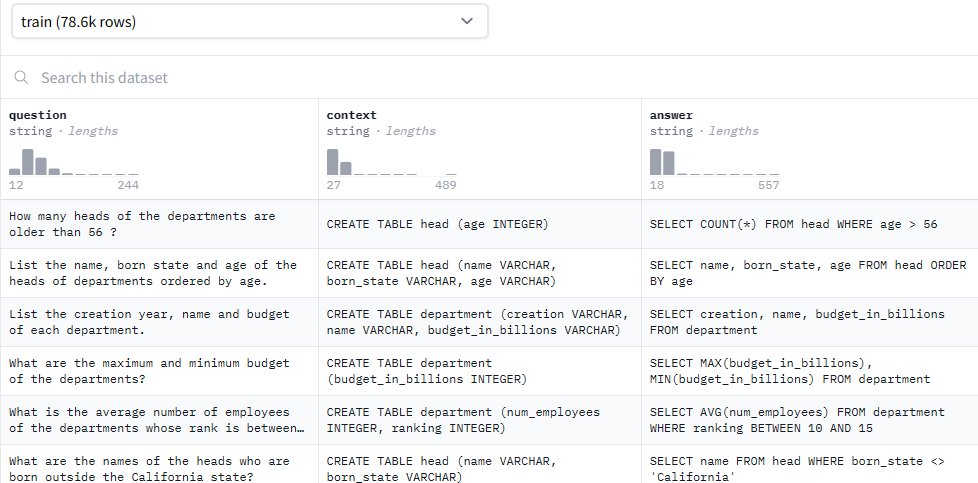

We'll use chatml format for the string/tokenization.

First though, we need to prep the dataset rows into a format that `trl` understands. Thankfully, the openai `messages` format has pretty wide adoption, including `trl`.

Each we'll create a list conatining elements for each row in the format:

```python
formatted_dataset_rows = [
    {"messages": [{"role": "system", "content": "You are..."}, {"role": "user", "content": "..."},  {"role": "assistant", "content": "..."}]}, 
    {"messages": ...
]
```

In [3]:
from datasets import load_dataset

# Convert dataset to OAI messages
system_message = """You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA.
SCHEMA:
{schema}"""

def create_conversation(sample):
  return {
    "messages": [
      {"role": "system", "content": system_message.format(schema=sample["context"])},
      {"role": "user", "content": sample["question"]},
      {"role": "assistant", "content": sample["answer"]}
    ]
  }

# Load dataset from the hub
dataset = load_dataset("b-mc2/sql-create-context", split="train")
dataset = dataset.shuffle().select(range(12500))

# Convert dataset to OAI messages
dataset = dataset.map(create_conversation, remove_columns=dataset.features,batched=False)
# split dataset into 10,000 training samples and 2,500 test samples
dataset = dataset.train_test_split(test_size=2500/12500)

print(dataset["train"][345]["messages"])

# save datasets to disk
dataset["train"].to_json("train_dataset.json", orient="records")
dataset["test"].to_json("test_dataset.json", orient="records")


Map:   0%|          | 0/12500 [00:00<?, ? examples/s]

[{'content': 'You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA.\nSCHEMA:\nCREATE TABLE table_name_15 (first_class_team VARCHAR, bowling_style VARCHAR)', 'role': 'system'}, {'content': 'What is the name of the First Class Team in which the player has a bowling style of left arm orthodox spin?', 'role': 'user'}, {'content': 'SELECT first_class_team FROM table_name_15 WHERE bowling_style = "left arm orthodox spin"', 'role': 'assistant'}]


Creating json from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

1188473

In [4]:
import os
os.listdir()

['test_dataset.json', 'train_dataset.json']

# Supervised Fine-Tuning

This is a pretty (surprisingly, if you've been in deep learning for a while) turnkey process at this point with fine-tuning and QLoRA. That said, there's no optimisation here of params as we'd do for a real-use case.

The `trl` trainer wraps QLoRA training, bitsandbytes and underlying Hugging Face Trainer, Accelerate etc. for very little code and boilerplate but still some knobs to tweak

#### Chat template formatting

- We're starting from a base-model, not instruction tuned
- This means we have the choice to set the instruction format any way we want
- Although we're using Mistral, the OpenAI chatml format is more widely used and available in libraries/ servers etc.
- So, use that rather than the `[INST] ... [/INST]` used by Mistral
- `trl` has a convenience class to set this for any prompts that adds the necessary BOS, EOS tokens and a`chat_template` to the tokenizer that can be used via `apply_chat_template()`
- https://github.com/huggingface/trl/pull/1242/files/050644063ca22718eaac4fd09deffc2c6c21ba58#top
- We'll be adding the tokens to the tokenizer, increasing the embedding size to a multiple of 64 to align with GPU mem boundaries
- Specifically for `chatml` this looks like the following (from the `trl` code linked above)

    ```python
    bos_token: str = "<|im_start|>"
    eos_token: str = "<|im_end|>"
    pad_token: str = "<|im_end|>"

    @property
    def system(self):
        return f"{self.bos_token}system"

    @property
    def user(self):
        return f"{self.bos_token}user"

    @property
    def assistant(self):
        return f"{self.bos_token}assistant"

    @property
    def chat_template(self):
        return (
            "{% for message in messages %}"
            f"{{'{self.bos_token}' + message['role'] + '\n' + message['content'] + eos_token + '\n'}}"
            "{% endfor %}"
            "{% if add_generation_prompt %}"
            f"{{ '{self.assistant}\n' }}"
            "{% endif %}"
        )
    ```

- Then we can use it via

    ```python
    model, tokenizer = setup_chat_format(model, tokenizer)
    ```

In [ ]:
from datasets import load_dataset

# Load jsonl data from disk
dataset = load_dataset("json", data_files="train_dataset.json", split="train")

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from trl import setup_chat_format

model_id = "mistralai/Mistral-7B-v0.1"  # comparison with code-llama would be interesting here

# BitsAndBytesConfig int-4 config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, bnb_4bit_use_double_quant=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16
)

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    attn_implementation="flash_attention_2",
    torch_dtype=torch.bfloat16,
    quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.padding_side = 'right' # to prevent warnings

# setup chatml prompt formatting and add special tokens to the tokenizer e.g. `<|user|>`
model, tokenizer = setup_chat_format(model, tokenizer)

We've loaded the models quantised. SFTTrainer just needs the LoRA config so we can run QLoRA training.

Using params based on the [QLoRA](https://arxiv.org/pdf/2305.14314.pdf) and [Sebastian Raschka's blog](https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms) which compared lots of different params and approaches

In [7]:
from peft import LoraConfig

# based on the [QLoRA](https://arxiv.org/pdf/2305.14314.pdf)
# and [Sebastian Raschka's blog](https://magazine.sebastianraschka.com/p/practical-tips-for-finetuning-llms)
peft_config = LoraConfig(
        lora_alpha=128,
        lora_dropout=0.05,
        r=256,
        bias="none",
        target_modules="all-linear",
        task_type="CAUSAL_LM",
)

In [8]:
hf_repo_id = f"dteome/{model_id.split('/')[-1]}-SQL"
hf_repo_id

'dteome/Mistral-7B-v0.1-SQL'

In [9]:
# from huggingface_hub import HfApi

# api = HfApi()
# api.create_repo(repo_id="super-cool-model", private=True)

In [9]:
from transformers import TrainingArguments

# using:
# gradient checkpointing to reduce memory requirements
# gradient accumulation to increase batch size and speed up training
# bf16 and tf32 for ops where quantised weights are not supported and accumulations, resp.
# gradient clipping and leraning rate warmup followed by constant
# must be logged into wandb to use, or change to tensorboard for local logging -- output_dir used as project name
# must be logged into huggingface to use push_to_hub
args = TrainingArguments(
    output_dir=hf_repo_id,
    hub_model_id=hf_repo_id,
    num_train_epochs=3,
    per_device_train_batch_size=3,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=10,
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    tf32=True,
    max_grad_norm=0.3,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=True,
    report_to="wandb",
)

In [10]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from trl import SFTTrainer

max_seq_length = 3072 # max sequence length for model and packing of the dataset

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=dataset,
    peft_config=peft_config,
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    packing=True,
    dataset_kwargs={
        "add_special_tokens": False,  # We template with special tokens
        "append_concat_token": False, # No need to add additional separator token
    }
)

In [ ]:
trainer.train()
trainer.save_model()

In [ ]:
trainer.save_model()

Clear the memory and load the model again cleanly. We've only stored the adaptor layers, so we need to use a different loader that takes those layers and also finds the full-model from it's config.

We could have merged the adaptor layers into the model, but that could exceed 30GB system RAM. If the model is to be used for inference in other frameworks, e.g. vLLM, this would be necessary

In [ ]:
# from peft import PeftModel, PeftConfig
# from transformers import AutoModelForCausalLM, AutoTokenizer
# from peft import AutoPeftModelForCausalLM

# # Load PEFT model on CPU
# config = PeftConfig.from_pretrained(args.output_dir)
# model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path,low_cpu_mem_usage=True)
# tokenizer = AutoTokenizer.from_pretrained(args.output_dir)
# model.resize_token_embeddings(len(tokenizer))
# model = PeftModel.from_pretrained(model, args.output_dir)
# model = AutoPeftModelForCausalLM.from_pretrained(
#     args.output_dir,
#     torch_dtype=torch.float16,
#     low_cpu_mem_usage=True,
# )
# # Merge LoRA and base model and save
# merged_model = model.merge_and_unload()
# merged_model.save_pretrained(args.output_dir,safe_serialization=True, max_shard_size="2GB")

In [ ]:
import gc
del model
# del trainer
gc.collect()
torch.cuda.empty_cache()

In [3]:
!ls dteome

Mistral-7B-v0.1-SQL


## Evaluation/ manual testing

For proper testing, EleutherAI's [lm-evaluation-harness](https://github.com/EleutherAI/lm-evaluation-harness) is a good choice.

We'll just get a vibe check here though

In [1]:
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer, pipeline

model_id = "mistralai/Mistral-7B-v0.1"
peft_model_id = "dteome/Mistral-7B-v0.1-SQL"
# peft_model_id = args.output_dir

# Load tokenizer if we've restarted the notebook
tokenizer = AutoTokenizer.from_pretrained(peft_model_id)
tokenizer.padding_side = 'right'

# Load Model with PEFT adapter
model = AutoPeftModelForCausalLM.from_pretrained(
  peft_model_id,
  device_map="auto",
  torch_dtype=torch.float16
)


# load into pipeline
pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MixtralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM',

In [3]:
tokenizer.chat_template

"{% for message in messages %}{{'<|im_start|>' + message['role'] + '\n' + message['content'] + '<|im_end|>' + '\n'}}{% endfor %}{% if add_generation_prompt %}{{ '<|im_start|>assistant\n' }}{% endif %}"

In [2]:
from datasets import load_dataset
from random import randint

# Load our test dataset
eval_dataset = load_dataset("json", data_files="test_dataset.json", split="train")
rand_idx = randint(0, len(eval_dataset))

# Test on sample
prompt = pipe.tokenizer.apply_chat_template(eval_dataset[rand_idx]["messages"][:2], tokenize=False, add_generation_prompt=True)
outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.1, top_k=50, top_p=0.1, eos_token_id=pipe.tokenizer.eos_token_id, pad_token_id=pipe.tokenizer.pad_token_id)

print(f"System:\n{eval_dataset[rand_idx]['messages'][0]['content']}")
print(f"Query:\n{eval_dataset[rand_idx]['messages'][1]['content']}")
print(f"Original Answer:\n{eval_dataset[rand_idx]['messages'][2]['content']}")
print(f"Generated Answer:\n{outputs[0]['generated_text'][len(prompt):].strip()}")

System:
You are an text to SQL query translator. Users will ask you questions in English and you will generate a SQL query based on the provided SCHEMA.
SCHEMA:
CREATE TABLE table_name_81 (home VARCHAR, date VARCHAR)
Query:
Who was the home team on June 9?
Original Answer:
SELECT home FROM table_name_81 WHERE date = "june 9"
Generated Answer:
SELECT home FROM table_name_81 WHERE date = "june 9"


In [3]:
from tqdm import tqdm

def evaluate(sample):
    prompt = pipe.tokenizer.apply_chat_template(sample["messages"][:2], tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.7, top_k=50, top_p=0.95, eos_token_id=pipe.tokenizer.eos_token_id, pad_token_id=pipe.tokenizer.pad_token_id)
    predicted_answer = outputs[0]['generated_text'][len(prompt):].strip()
    if predicted_answer == sample["messages"][2]["content"]:
        return 1
    else:
        return 0

success_rate = []
number_of_eval_samples = 1000
# iterate over eval dataset and predict
for s in tqdm(eval_dataset.shuffle().select(range(number_of_eval_samples))):
    success_rate.append(evaluate(s))

# compute accuracy
accuracy = sum(success_rate)/len(success_rate)

print(f"Accuracy: {accuracy*100:.2f}%")

  0%|          | 0/1000 [00:00<?, ?it/s]

  1%|          | 9/1000 [00:18<32:37,  1.97s/it]/home/dom/.local/lib/python3.10/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 1000/1000 [34:05<00:00,  2.05s/it]

Accuracy: 81.10%


Accuracy: 81.10%

## Inference servers

If the LoRA adaptors are merged, the best option now for inference would be vLLM (or quantize and run with e.g. llama.cpp).

Alternatively, there's the text-generation-inference server from Hugging Face

In [ ]:
%%bash
# model=$PWD/{args.output_dir} # path to model
model=$(pwd)/"dteome/Mistral-7B-v0.1-SQL"
num_shard=1
max_input_length=1024
max_total_tokens=2048

docker run -d --name tgi --gpus all -ti -p 8080:80 \
  -e MODEL_ID=/workspace \
  -e NUM_SHARD=$num_shard \
  -e MAX_INPUT_LENGTH=$max_input_length \
  -e MAX_TOTAL_TOKENS=$max_total_tokens \
  -v $model:/workspace \
  ghcr.io/huggingface/text-generation-inference:latest

In [ ]:
import requests as r
from transformers import AutoTokenizer
from datasets import load_dataset
from random import randint

# Load our test dataset and Tokenizer again
tokenizer = AutoTokenizer.from_pretrained("dteome/Mistral-7B-v0.1-SQL")
eval_dataset = load_dataset("json", data_files="test_dataset.json", split="train")
rand_idx = randint(0, len(eval_dataset))

# generate the same prompt as for the first local test
prompt = tokenizer.apply_chat_template(eval_dataset[rand_idx]["messages"][:2], tokenize=False, add_generation_prompt=True)
request= {"inputs":prompt,"parameters":{"temperature":0.2, "top_p": 0.95, "max_new_tokens": 256}}

# send request to inference server
resp = r.post("http://127.0.0.1:8080/generate", json=request)

output = resp.json()["generated_text"].strip()
time_per_token = resp.headers.get("x-time-per-token")
time_prompt_tokens = resp.headers.get("x-prompt-tokens")

# Print results
print(f"Query:\n{eval_dataset[rand_idx]['messages'][1]['content']}")
print(f"Original Answer:\n{eval_dataset[rand_idx]['messages'][2]['content']}")
print(f"Generated Answer:\n{output}")
print(f"Latency per token: {time_per_token}ms")
print(f"Latency prompt encoding: {time_prompt_tokens}ms")